# Installation Setup

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
from fredapi import Fred
fred = Fred(api_key = 'b0363f9c9d853b92b27e06c4727bc2ea')
import pandas_datareader.data as web

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [28]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import StockPortfolioEnv

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [29]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

# Data

In [30]:
Datasets = os.path.dirname(os.getcwd()) + "\\data\\"
__depends__ = [Datasets+"RetailMarketOrder.sas7bdat", 
               Datasets+"InstitutionOrder.sas7bdat", 
               Datasets+"FutureReturn.sas7bdat"]
__dest__ = []

In [31]:
__depends__

['D:\\Google Drive - Columbia University\\AI4Finance\\Imitation Learning\\data\\RetailMarketOrder.sas7bdat',
 'D:\\Google Drive - Columbia University\\AI4Finance\\Imitation Learning\\data\\InstitutionOrder.sas7bdat',
 'D:\\Google Drive - Columbia University\\AI4Finance\\Imitation Learning\\data\\FutureReturn.sas7bdat']

## Column Details

- permno is the permanent stock identifier used in CRSP
- Retail Market Order Imbalance (moribvol) = (Shares Purchased - Shares Sold)/(Shares Purchased+Shares Sold)
    - We standardize by dividing the sum of total buy and sell retail market orders to make this variable comparable across different stocks
    - Tracking Retail Investor Activity: https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.13033
- 5 Russell groups
    - Classification of stocks according to the constituent members of Russell indices
    - Large-Cap (russellgroup = 1): stocks in Russell Top 200, which consists of the largest 200 members in Russell 1000
    - Mid-Cap (russellgroup = 2): stocks in Russell Mid-Cap, which consists of the smallest 800 members in Russell 1000
    - Small-Cap (russellgroup = 3): the largest 1000 members in Russell 2000
    - Micro-Cap (russellgroup = 4): stocks in Russell Micro-Cap, which consists of the smallest 1000 members in Russell 2000 plus the largest 1000 stocks outside Russell 2000
    - Nano-Cap (russellgroup = 5): all remaining stocks
- 11 sectors
    - The Global Industry Classification Standard (GICS)
    - I name a sector using the corresponding ticker of the SPDR sector ETF (see, https://www.sectorspdr.com/sectorspdr/)

In [32]:
retail = pd.read_sas(__depends__[0], encoding = 'latin-1')
retail.columns = retail.columns.str.lower()
retail[['permno','russellgroup']] = retail[['permno','russellgroup']].astype(int)
retail.tail()

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,moribvol
14431820,93436,TSLA,TESLA INC,2021-12-27,1,XLY,"1,093.940","1,098,605.595",0.001
14431821,93436,TSLA,TESLA INC,2021-12-28,1,XLY,"1,088.470","1,093,112.295",-0.021
14431822,93436,TSLA,TESLA INC,2021-12-29,1,XLY,"1,086.190","1,090,822.542",-0.033
14431823,93436,TSLA,TESLA INC,2021-12-30,1,XLY,"1,070.340","1,074,904.966",-0.007
14431824,93436,TSLA,TESLA INC,2021-12-31,1,XLY,"1,056.780","1,092,190.615",-0.087


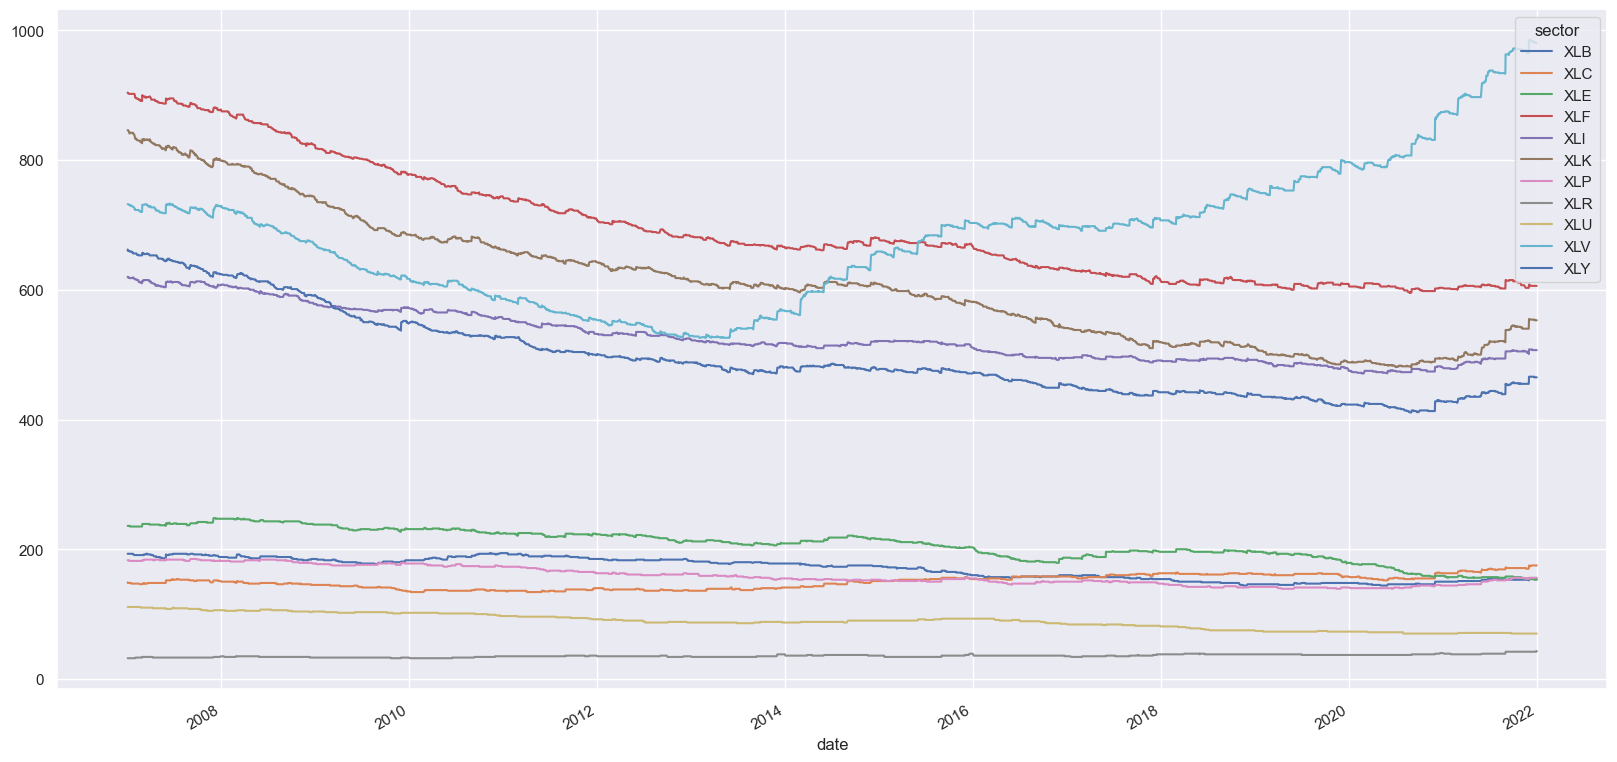

In [34]:
retail.groupby(['date','sector'])['permno'].count().unstack().plot();

In [35]:
institution = pd.read_sas(__depends__[1], encoding = 'latin-1')
institution.columns = institution.columns.str.lower()
institution[['permno','russellgroup']] = institution[['permno','russellgroup']].astype(int)
institution.tail()

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,iibvol
10772976,93436,TSLA,TESLA MOTORS INC,2011-03-25,2,XLY,22.750,"2,168.871",0.000
10772977,93436,TSLA,TESLA MOTORS INC,2011-03-28,2,XLY,23.250,"2,216.539",1.000
10772978,93436,TSLA,TESLA MOTORS INC,2011-03-29,2,XLY,23.920,"2,280.413",0.000
10772979,93436,TSLA,TESLA MOTORS INC,2011-03-30,2,XLY,23.710,"2,260.393",0.000
10772980,93436,TSLA,TESLA MOTORS INC,2011-03-31,2,XLY,27.750,"2,651.651",-1.000


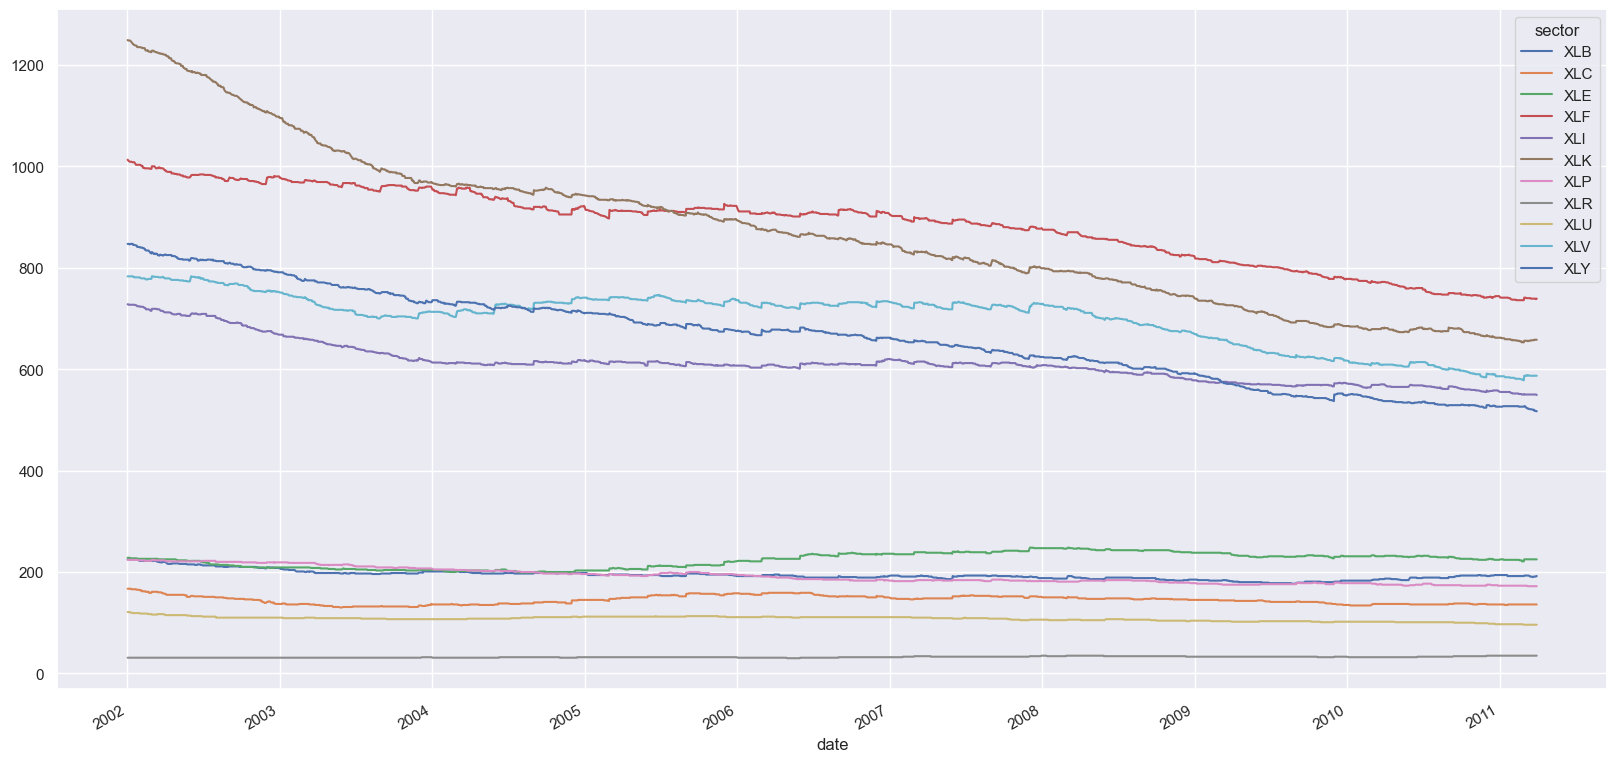

In [36]:
institution.groupby(['date','sector'])['permno'].count().unstack().plot();

In [37]:
ret = pd.read_sas(__depends__[2], encoding = 'latin-1')
ret.columns = ret.columns.str.lower()
ret['permno'] = ret['permno'].astype(int)
ret.tail()

,permno,date,ret_1,ret_5,ret_10,ret_20
21466675,93436,2021-12-27,-0.005,0.097,-0.033,-0.160
21466676,93436,2021-12-28,-0.002,0.056,-0.022,-0.139
21466677,93436,2021-12-29,-0.015,0.002,0.018,-0.237
21466678,93436,2021-12-30,-0.013,-0.005,-0.036,-0.209
21466679,93436,2021-12-31,0.135,-0.028,-0.007,-0.114


- ret_i, i = 1,5,10,20, is the return over next day, 5 days, 10 days, 20 days
    - I already moved the return backward for one trading day to avoid potentisl forward-looking bias. For example, -0.003 ret_1 of stock 93436 at 2022-06-24 is the return earned by this stock at 2022-06-27

# More Data Explorations
> In hindsight, we present stock correlation anaysis between imbalance trades and return rates in 5 days, as an example 

In [38]:
# All data points - merged retail imblance trades and returns rates
retail_ret = pd.merge(retail[['ticker','permno','date','moribvol', "russellgroup", "sector", "price"]], ret, on = ['permno','date'], how = 'inner')
retail_ret = retail_ret.rename(columns={'ticker': 'tic'})
retail_ret

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20
0,EWST,10001,2007-01-03,-1.000,5,XLU,11.100,0.023,-0.000,0.035,0.027
1,EWST,10001,2007-01-04,0.000,5,XLU,11.360,-0.010,0.008,-0.018,-0.014
2,EWST,10001,2007-01-05,0.000,5,XLU,11.250,0.008,0.010,-0.004,0.019
3,EWST,10001,2007-01-08,0.000,5,XLU,11.345,-0.009,-0.002,0.010,0.004
4,EWST,10001,2007-01-09,1.000,5,XLU,11.240,-0.012,0.019,0.019,0.014
...,...,...,...,...,...,...,...,...,...,...,...
14431820,TSLA,93436,2021-12-27,0.001,1,XLY,"1,093.940",-0.005,0.097,-0.033,-0.160
14431821,TSLA,93436,2021-12-28,-0.021,1,XLY,"1,088.470",-0.002,0.056,-0.022,-0.139
14431822,TSLA,93436,2021-12-29,-0.033,1,XLY,"1,086.190",-0.015,0.002,0.018,-0.237
14431823,TSLA,93436,2021-12-30,-0.007,1,XLY,"1,070.340",-0.013,-0.005,-0.036,-0.209


In [39]:
# Correlation anaysis between imbalance trades and return rates in 5 days
fut_ret = 'ret_5'

# tic, russellgroup, and sector may be changed with respect to a company over time...
grouped = retail_ret.groupby(['permno', 'tic', "russellgroup", "sector"])

df_correlation = grouped.apply(lambda x: x['moribvol'].corr(x[fut_ret])).dropna()
df_correlation = df_correlation[df_correlation > 0].reset_index()
df_correlation = df_correlation.rename(columns={df_correlation.columns[-1]: 'corr'})

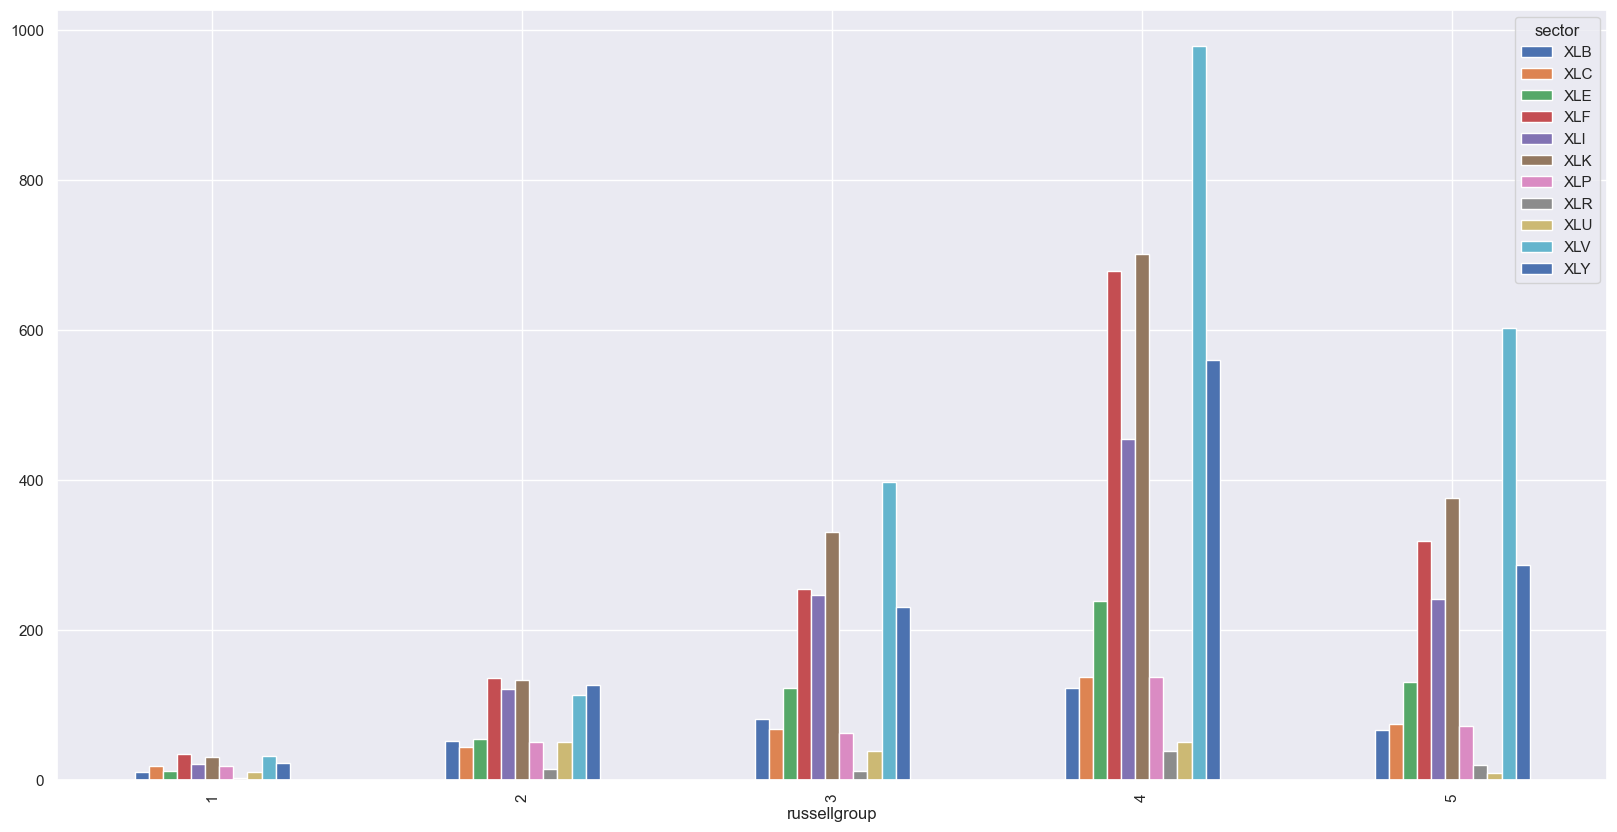

In [40]:
df_correlation.groupby(['russellgroup','sector'])['permno'].count().unstack().plot.bar();

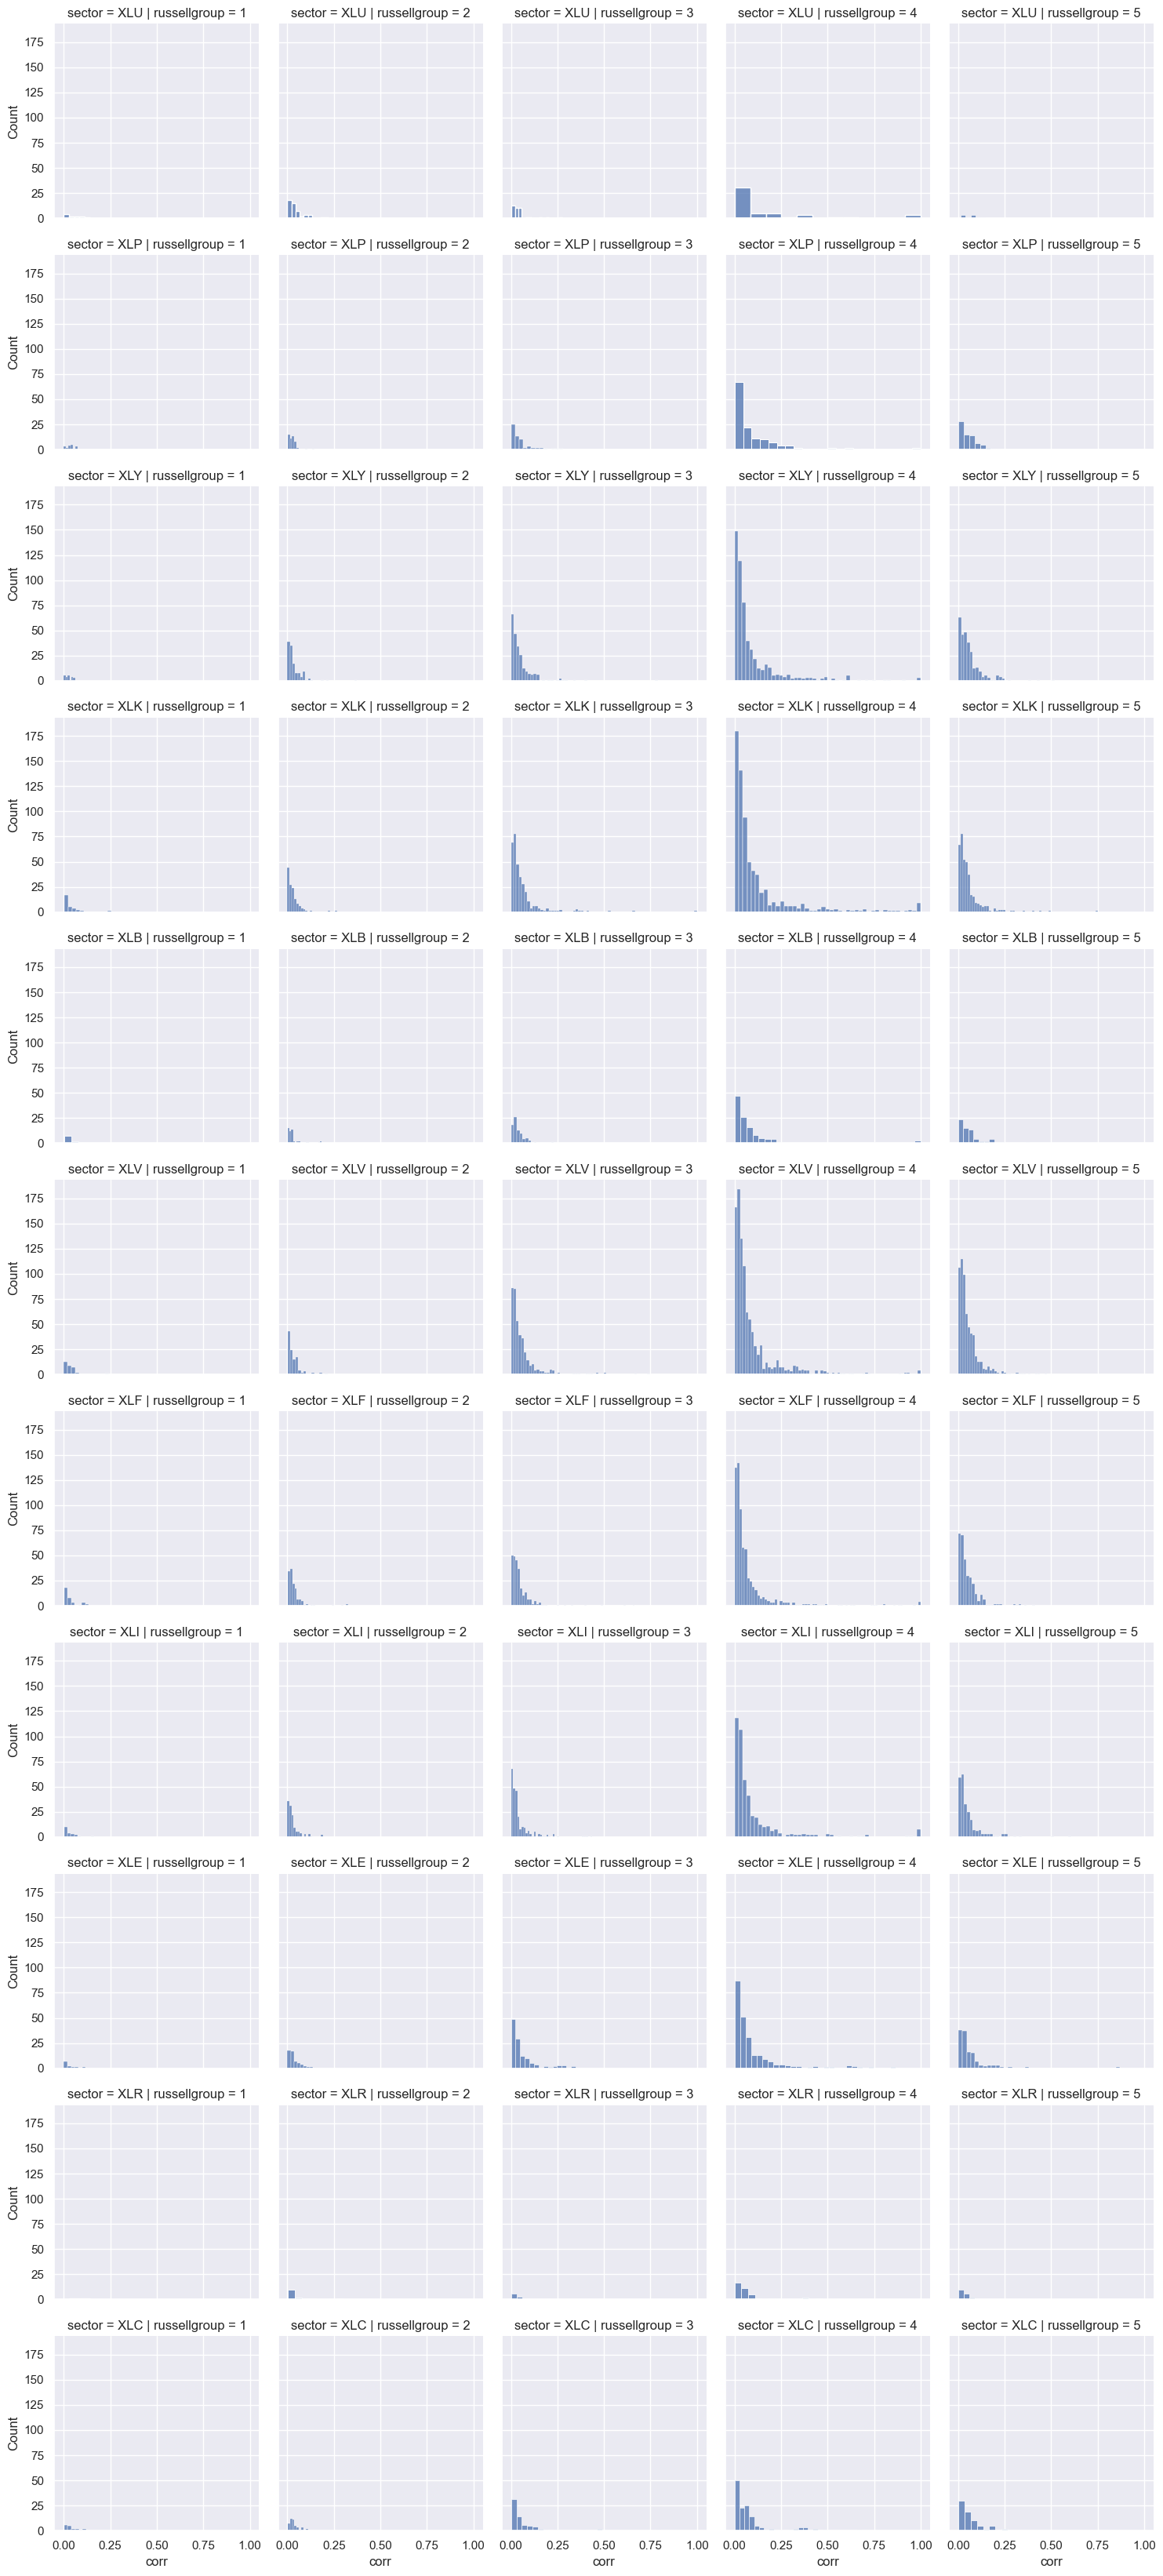

In [41]:
# A panel of plots of correlation values
g = sns.FacetGrid(df_correlation, col='russellgroup', row='sector')
g.map(sns.histplot, 'corr', kde=False)
g.fig.tight_layout()
g.fig.show()

sector
XLB    AxesSubplot(0.125,0.11;0.775x0.77)
XLC    AxesSubplot(0.125,0.11;0.775x0.77)
XLE    AxesSubplot(0.125,0.11;0.775x0.77)
XLF    AxesSubplot(0.125,0.11;0.775x0.77)
XLI    AxesSubplot(0.125,0.11;0.775x0.77)
XLK    AxesSubplot(0.125,0.11;0.775x0.77)
XLP    AxesSubplot(0.125,0.11;0.775x0.77)
XLR    AxesSubplot(0.125,0.11;0.775x0.77)
XLU    AxesSubplot(0.125,0.11;0.775x0.77)
XLV    AxesSubplot(0.125,0.11;0.775x0.77)
XLY    AxesSubplot(0.125,0.11;0.775x0.77)
Name: corr, dtype: object

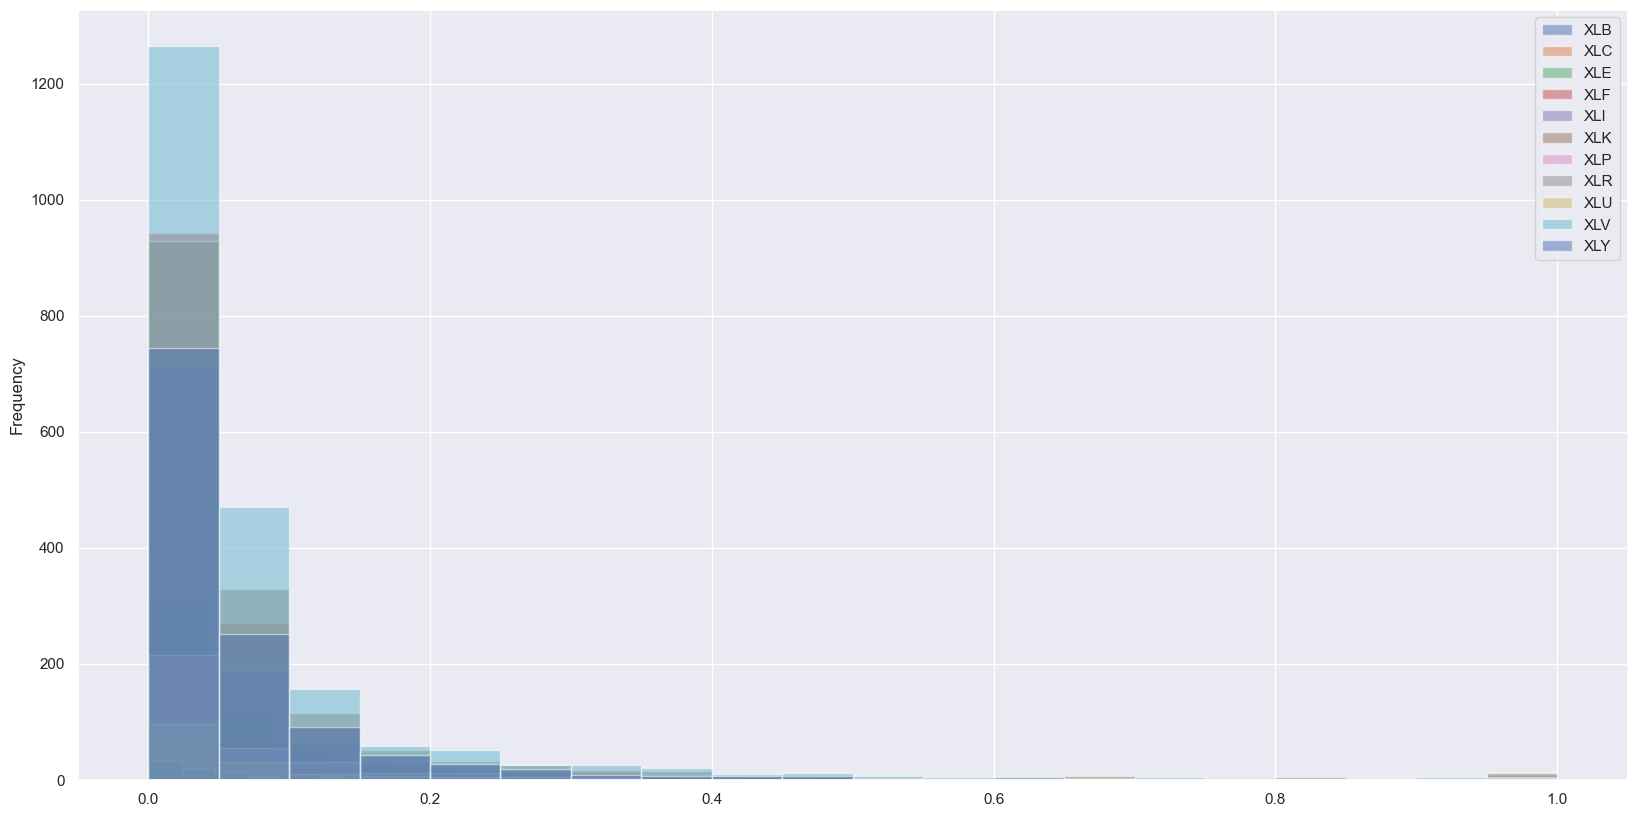

In [42]:
# Plot the distribution of correlation values for each sectors
grouped = df_correlation.groupby(['sector'])
grouped['corr'].plot.hist(alpha=0.5, bins=20)

plt.legend()
plt.show()

In [43]:
# Max correlated stocks in different cap sizes and sectors

def get_max_row(group):
    return group[group['corr'] == group['corr'].max()].iloc[0, :]

df_correlation.groupby(['russellgroup','sector']).apply(get_max_row)

permno   tic  russellgroup sector  corr
russellgroup sector                                         
1            XLB      16851  DWDP             1    XLB 0.229
             XLC      91066   VIA             1    XLC 0.121
             XLE      13141   WPX             1    XLE 0.118
             XLF      64565   CFC             1    XLF 0.134
             XLI      11955   WMI             1    XLI 0.162
             XLK      14926   CDK             1    XLK 0.256
             XLP      18163    PG             1    XLP 0.073
             XLR      91388     H             1    XLR 0.140
             XLU      24563   TXU             1    XLU 0.142
             XLV      16544  BIVV             1    XLV 0.244
             XLY      66181    HD             1    XLY 0.061
2            XLB      15917   GCP             2    XLB 0.184
             XLC      79903   HHS             2    XLC 0.114
             XLE      90180  ATLS             2    XLE 0.139
             XLF      81593    WM             2    XLF 0.326
             XLI      81285    TT             2    XLI 0.191
             XLK      81705  FEIC             2    XLK 0.267
             XLP      52038   SYY             2    XLP 0.145
             XLR      14252  GLPI             2    XLR 0.304
             XLU      14401   OGS             2    XLU 0.222
             XLV      86923   TRI             2    XLV 0.216
             XLY      18578   KTB             2    XLY 0.375
3            XLB      18075    AP             3    XLB 0.231
             XLC      92265   RCH             3    XLC 0.806
             XLE      90674   AEZ             3    XLE 0.348
             XLF      15180  ICBK             3    XLF 0.666
             XLI      91299   GFN             3    XLI 0.437
             XLK      80236  DSPG             3    XLK 1.000
             XLP      76461  VERU             3    XLP 0.282
             XLR      38746   AXR             3    XLR 0.412
             XLU      91840    RZ             3    XLU 0.276
             XLV      16670  CATS             3    XLV 0.746
             XLY      87379  CLCT             3    XLY 0.790
4            XLB      10881  ANLT             4    XLB 1.000
             XLC      65787   TRB             4    XLC 0.682
             XLE      83991   THX             4    XLE 0.867
             XLF      86300  PCBS             4    XLF 1.000
             XLI      21020   AMR             4    XLI 1.000
             XLK      15797  CSRA             4    XLK 1.000
             XLP      13598  KRFT             4    XLP 1.000
             XLR      91388     H             4    XLR 0.470
             XLU      77495  MWAV             4    XLU 1.000
             XLV      66368   CTT             4    XLV 1.000
             XLY      11873  DISK             4    XLY 1.000
5            XLB      91946   SHJ             5    XLB 0.385
             XLC      17323  LIVX             5    XLC 0.833
             XLE      79393  EWEB             5    XLE 0.871
             XLF      10682  UBMT             5    XLF 0.412
             XLI      18533   RMO             5    XLI 0.607
             XLK      15410  APPF             5    XLK 0.753
             XLP      89447  CVGW             5    XLP 0.234
             XLR      20147  HFEN             5    XLR 0.294
             XLU      84345  USEY             5    XLU 0.150
             XLV      19397   TOI             5    XLV 0.479
             XLY      18936    XL             5    XLY 0.519

# Stock Selection

> Pick 11 Large Cap Tech (XLK) firms whose retail investor trades are significantly correlatede with return rates in 5 days.
> Stocks are ["QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "INTU", "WU", "LRCX", "TXN", "CSCO"]

In [44]:
# stock_grp = ['Large-Cap','Mid-Cap','Small-Cap','Micro-Cap','Nano-Cap']
# tech_largeCap = retail[(retail["sector"] == 'XLK')]

tech_largeCap = retail[(retail["sector"] == 'XLK')& (retail["russellgroup"] == 1)]
tech_largeCap_ret = pd.merge(tech_largeCap[['ticker','permno','date','moribvol', "price", "russellgroup"]], 
                             ret, 
                             on = ['permno','date'], 
                             how = 'inner')

tech_largeCap_ret

,ticker,permno,date,moribvol,price,russellgroup,ret_1,ret_5,ret_10,ret_20
0,SUNW,10078,2007-01-03,-0.161,5.540,1,0.027,0.083,0.045,0.182
1,SUNW,10078,2007-01-04,0.236,5.690,1,-0.016,0.079,0.014,0.165
2,SUNW,10078,2007-01-05,0.254,5.600,1,0.009,0.082,0.027,0.186
3,SUNW,10078,2007-01-08,-0.294,5.650,1,0.014,0.073,0.002,0.156
4,SUNW,10078,2007-01-09,0.762,5.730,1,0.047,0.045,0.073,0.150
...,...,...,...,...,...,...,...,...,...,...
88785,AOL,93091,2010-05-24,-0.040,21.200,1,-0.025,-0.033,-0.041,0.082
88786,AOL,93091,2010-05-25,0.038,20.680,1,0.002,0.015,-0.023,0.095
88787,AOL,93091,2010-05-26,-0.280,20.720,1,0.021,0.014,0.019,0.049
88788,AOL,93091,2010-05-27,0.159,21.160,1,-0.025,0.006,-0.008,0.038


In [45]:
tech_largeCap_ret['ticker'].unique()

array(['SUNW', 'JAVA', 'ORCL', 'MSFT', 'EMC', 'FISV', 'DELL', 'MMI',
       'IBM', 'NOW', 'WDAY', 'AAPL', 'AMAT', 'CDK', 'PYPL', 'TXN', 'HPE',
       'SQ', 'VSM', 'ZM', 'GLW', 'MOT', 'MSI', 'HPQ', 'DXC', 'ADP',
       'LRCX', 'MU', 'INTC', 'ADI', 'AMD', 'ADBE', 'SYMC', 'CSCO', 'QCOM',
       'FDC', 'INTU', 'NTAP', 'ADSK', 'BRCM', 'CTSH', 'NVDA', 'JNPR',
       'GPN', 'FIS', 'CRM', 'MA', 'WU', 'FSLR', 'VMW', 'V', 'AVGO', 'AOL'],
      dtype=object)

In [46]:
fut_ret = 'ret_5'
grouped = tech_largeCap_ret.groupby('permno')

tech_largeCap_correlation = grouped.apply(lambda x: x['moribvol'].corr(x[fut_ret])).dropna()
tech_largeCap_correlation = tech_largeCap_correlation.sort_values(ascending=False).reset_index()
tech_largeCap_correlation = tech_largeCap_correlation.rename(columns={tech_largeCap_correlation.columns[-1]: 'corr'})

tech_largeCap_correlation = tech_largeCap_correlation.merge(tech_largeCap_ret[['ticker', 'permno', "russellgroup"]], on='permno')
tech_largeCap_correlation = tech_largeCap_correlation.drop_duplicates()
tech_largeCap_correlation

,permno,corr,ticker,russellgroup
0,14926,0.256,CDK,1
124,40125,0.105,DXC,1
165,18484,0.082,ZM,1
567,77546,0.073,FDC,1
735,77178,0.055,QCOM,1
4512,85631,0.052,ADSK,1
5145,91611,0.051,FSLR,1
5648,10078,0.045,SUNW,1
5811,10078,0.045,JAVA,1
6003,10107,0.044,MSFT,1


In [47]:
selected_tech_tic = ["QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "INTU", "WU", "LRCX", "TXN", "CSCO"]
selected_tech_ret = retail_ret[retail_ret['tic'].isin(selected_tech_tic)]

# Earliest date of public trades
min(selected_tech_ret['date'])

# latest date of public trades
max(selected_tech_ret['date'])

# Check if their lengths are consistent
assert selected_tech_ret.groupby(["permno", "tic"]).size().nunique() == 1

# Sort by date 
selected_tech_ret = selected_tech_ret.sort_values(['date','tic'])

Timestamp('2007-01-03 00:00:00')

Timestamp('2021-12-31 00:00:00')

## Data Merge with Technical Indicators

In [48]:
from datetime import datetime as dt

tz = pytz.timezone("America/New_York")
start = tz.localize(dt(2007,1,3))
end = tz.localize(dt.today())

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

# yf_tech = YahooDownloader(start_date = start,
#                           end_date = end,
#                           ticker_list = selected_tech_tic).fetch_data()

# # Stack
# processed = fe.preprocess_data(yf_tech)

processed = pd.DataFrame()
for symbol in selected_tech_tic:
    yf_symbol = YahooDownloader(start_date = start, end_date = end, ticker_list = [symbol]).fetch_data()
    processed_symbol = fe.preprocess_data(yf_symbol)
    processed = pd.concat([processed, processed_symbol], axis=0)

processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)
processed['date'] = pd.to_datetime(processed['date'])

processed

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4074, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4074, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4074, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4074, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4074, 8)
Successfully added technical indicators
Successfully added turbulence index
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4074, 8)
Successfully added t

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2007-01-03,37.760,38.770,36.790,25.494,24184800,QCOM,2,0.000,27.696,24.442,100.000,66.667,100.000,25.494,25.494,0.000
1,2007-01-04,37.790,39.400,37.400,26.644,26164600,QCOM,3,0.026,27.696,24.442,100.000,66.667,100.000,26.069,26.069,0.000
2,2007-01-05,38.900,38.940,37.870,26.331,18403600,QCOM,4,0.023,27.346,24.967,78.028,39.846,100.000,26.156,26.156,0.000
3,2007-01-08,38.750,38.750,38.000,26.038,13545200,QCOM,0,0.011,27.105,25.149,64.356,15.586,100.000,26.127,26.127,0.000
4,2007-01-09,38.500,38.650,37.840,25.753,15948700,QCOM,1,-0.007,26.963,25.141,54.675,-27.419,52.646,26.052,26.052,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,2023-03-03,48.990,49.360,48.820,49.280,15967000,CSCO,4,0.227,50.786,46.289,54.652,68.537,8.933,48.415,48.120,0.735
4070,2023-03-06,49.460,49.810,49.240,49.420,13878400,CSCO,0,0.261,50.859,46.295,55.075,91.294,14.243,48.503,48.140,0.028
4071,2023-03-07,49.570,49.760,48.630,48.910,17506600,CSCO,1,0.243,50.880,46.408,53.206,51.955,5.342,48.550,48.159,0.310
4072,2023-03-08,49.020,49.270,48.740,49.110,12055500,CSCO,2,0.243,50.920,46.495,53.841,42.690,5.342,48.593,48.167,0.058


In [49]:
processed['tic'].unique()

array(['QCOM', 'ADSK', 'FSLR', 'MSFT', 'AMD', 'ORCL', 'INTU', 'WU',
       'LRCX', 'TXN', 'CSCO'], dtype=object)

In [ ]:
# Merge technical indicators with returns
df_merged = pd.merge(retail_ret, processed, on=['tic', 'date'])
df_merged.to_csv('data/merged.csv', index=False)  # set index=False to exclude row index from CSV file